## Add some additional years to the PPE start years
Add additional years to span width of ENSO spectrum. Visualize new statistics.  
Current years (following procedure in dev_startyears.ipynb): [ 123,  161,  185, 208, 230, 269, 300, 326, 359, 381]

In [5]:
import xarray as xr
import numpy as np
from xhistogram.xarray import histogram
import pandas as pd
import glob
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.stats
import gfdl_utils as gu

In [6]:
# Mass transport for AABW
paths = '../data/raw/CTRL/pp/ocean_annual_rho2/ts/annual/5yr/ocean_annual_rho2.0[1-3]*.vmo.nc'
ds = xr.open_mfdataset(glob.glob(paths),use_cftime=True)
# Surface temperature for ENSO
paths = '../data/raw/CTRL/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.0[1-3]*.tos.nc'
dstos = (xr.open_mfdataset(glob.glob(paths),use_cftime=True)
         # Use groupby to pick out years (coarsen doesn't like cftime)
         .groupby('time.year').mean().rename({'year':'time'})
         # Align coords with ds
         .assign_coords({'time':ds['time']}).drop('average_DT'))
# Surface salinity
paths = '../data/raw/CTRL/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.0[1-3]*.sos.nc'
dssos = (xr.open_mfdataset(glob.glob(paths),use_cftime=True)
         # Use groupby to pick out years (coarsen doesn't like cftime)
         .groupby('time.year').mean().rename({'year':'time'})
         # Align coords with ds
         .assign_coords({'time':ds['time']}).drop('average_DT'))
ds = xr.merge([ds,dstos,dssos])
# ds = xr.merge([dstos,dssos])
# Grid
gridpath = '../data/raw/CTRL/pp/ocean_monthly/ocean_monthly.static.nc'
grid = xr.open_mfdataset(glob.glob(gridpath))

In [7]:
def cumsum_r(da,dim):
    '''Reverse cumulative sum'''
    cumsum = da.reindex({dim:list(reversed(da[dim]))}).cumsum(dim)
    return cumsum.reindex({dim:list(reversed(cumsum[dim]))})

def calc_psi(vmo,latitude,zdim='rho2_l'):
    '''Calculate overturning streamfunction'''
    return cumsum_r(vmo.sum('xh').sel(yq=latitude,method='nearest'),dim='rho2_l')

def calc_maxpsi(vmo,latitude,zdim='rho2_l',threshold=1036.7):
    '''Retrieve maximum of psi in z-dimension'''
    psi = calc_psi(vmo,latitude,zdim=zdim)
    return psi.where(psi[zdim]>threshold).max(zdim)

def calc_nino34(tos,area):
    box_dict = {'xh':slice(-170,-120),'yh':slice(-5,5)}
    tos_box = tos.sel(**box_dict).weighted(area).mean(['xh','yh'])
    return (tos_box - tos_box.mean('time'))/tos_box.std('time')

def calc_sosalinity(sos,area):
    box_dict = {'yh':slice(-90,-55)}
    sos_box = sos.sel(**box_dict).weighted(area).mean(['xh','yh'])
    return sos_box

In [8]:
vmo = ds['vmo']
tos = ds['tos']
sos = ds['sos']
maxpsi = calc_maxpsi(vmo,-60)
maxpsi.name = 'maxpsi'
nino34 = calc_nino34(tos,grid['areacello'])
nino34.name = 'nino34'
sosalinity = calc_sosalinity(sos,grid['areacello'])
sosalinity.name = 'sosalinity'
with ProgressBar():
    maxpsi = maxpsi.load()
    nino34 = nino34.load()
    sosalinity = sosalinity.load()

[########################################] | 100% Completed | 47.7s
[########################################] | 100% Completed | 17.5s
[########################################] | 100% Completed | 18.5s


In [14]:
def grab(x):
    return np.random.choice(x,1)[0]

def find_years(groups):
    times = groups['time'].apply(grab)
    years = np.sort(times.to_numpy())
    return years

def eval_spacing(years,minspacing=10):
    return np.all(np.greater(np.diff(years),minspacing))

# def get_years_with_spacing(groups,minspacing=10,check_alt=False,alt_ts=None, thresholds=None):
#     success=False
#     ni=0
#     while not success:
#         years = find_years(groups)
#         success = eval_spacing(years,minspacing=minspacing)
#         if success:
#             print("FOUND : suitable years after {} iterations".format(ni))
#             print("Years : {}".format(years))
#             print("Spacing : {}".format(np.diff(years)))
#             if check_alt:
#                 success,full,sample = check_sample_meanstd(alt_ts,years,thresholds)
#                 if not allgreater:
#                     print("FAIL : years don't satisfy thresholds for alternative time-series")
#                     print("FAIL : ts mean {}, std {}".format(full[0].values,full[1].values))
#                     print("FAIL : sample ts mean {}, std {}".format(sample[0].values,sample[0].values))
#                 else:
#                     print("SUCCESS : years satisfy alternative timeseries thresholds")
#         ni+=1
#     return years

def get_years_with_spacing(groups,minspacing=10,check_alt=False,alt_ts=None, thresholds=None):
    success=False
    ni=0
    while not success:
        years = find_years(groups)
        success = eval_spacing(years,minspacing=minspacing)
        if success:
            print("FOUND : suitable years after {} iterations".format(ni))
            print("Years : {}".format(years))
            print("Spacing : {}".format(np.diff(years)))
        ni+=1
    return years

def check_sample_meanstd(ts,years,thresholds):
    '''Compare mean and std of sampled years to that of full time-series
    Input threshold as list of [threshold for mean, threshold for std]
    Outputs come as (boolean, [mean,std] for full ts, [mean,std] for sample)'''
    diffmean = np.abs(ts.mean('time') - ts.isel(time=years).mean('time'))
    diffstd = np.abs(ts.std('time') - ts.isel(time=years).std('time'))
    return (
        (diffmean<thresholds[0]) & (diffstd<thresholds[1]),
        [ts.mean('time'), ts.std('time')],
        [ts.isel(time=years).mean('time'),ts.isel(time=years).std('time')]
    )

def calc_jsd(p,q):
    """
    method to compute the Jenson-Shannon Distance 
    between two probability distributions
    """
    # from here https://medium.com/@sourcedexter/how-to-find-the-similarity-between-two-probability-distributions-using-python-a7546e90a08d
    # convert the vectors into numpy arrays in case that they aren't
    p = np.array(p)
    q = np.array(q)
    # calculate m
    m = (p + q) / 2
    # compute Jensen Shannon Divergence
    divergence = (scipy.stats.entropy(p, m) + scipy.stats.entropy(q, m)) / 2
    # If two distribution differ only at level of machine precision,
    # set divergence to zero (to avoid negative numbers)
    if divergence<0:
        divergence = 0
    # compute the Jensen Shannon Distance
    distance = np.sqrt(divergence)
    return distance

def get_jsd(ts,years,bins=30):
    p,q,_ = get_distributions(ts,years,bins)
    return calc_jsd(p,q)

def get_quantile_bins(ts):
    return ts.quantile(q=np.arange(0,1.1,0.1)).to_numpy()

def get_distributions(ts,years,bins=30):
    if isinstance(bins,int):
        bins = np.linspace(np.min(ts),np.max(ts),bins)
    sample = ts.isel(time=years)
    # Get pdf for full time-series
    ts_hist = histogram(ts,bins=[bins],dim=['time'],density=True)
    # Get pdf for sample
    sample_hist = histogram(sample,bins=[bins],dim=['time'],density=True)
    return ts_hist,sample_hist,bins

def plot_distributions(ts,years,bins=30,
                       print_years=True,print_jsd=True,
                       savefig=False):
    sample = ts.isel(time=years)
    ts_hist,sample_hist,bin_edges = get_distributions(ts,years,bins=bins)
    
    fig = plt.figure(constrained_layout=True,figsize=(15,5))
    spec = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)
    ax1 = fig.add_subplot(spec[0:2])
    ax2 = fig.add_subplot(spec[2])

    ax1.plot(ts['time'],ts)
    ax1.plot(sample['time'],sample,'o',markersize=12)
    ax1.set_xlabel('Time')
    ax1.autoscale(enable=True, axis='x', tight=True)
    if print_years:
        ylims = ax1.get_ylim()
        ypos = ylims[0]-np.diff(ylims)*0.2
        ax1.text(ts['time'][0].values,ypos,
                 "Years : "+np.array2string(years,separator=', ')+
                 ";  Min. spacing : "+str(np.min(np.diff(years))),fontsize=16)

    ax2.plot(ts_hist[ts.name+'_bin'],ts_hist)
    ax2.bar(sample_hist[sample.name+'_bin'],sample_hist,width=np.diff(bin_edges),color='tab:orange',alpha=0.5,edgecolor='tab:orange')
    ax2.set_ylabel('probability density') 
    if print_jsd:
        xlims = ax2.get_xlim()
        ylims = ax2.get_ylim()
        xpos = xlims[0]+np.diff(xlims)*0.1
        ypos = ylims[1]-np.diff(ylims)*0.1
        
        distance = get_jsd(ts,years)
        ax2.text(xpos,ypos,"JSD : {}".format(distance))
    
    if savefig:
        fig.savefig('../figures/ts_pdf.'+ts.name+'.png')


In [15]:
years_orig = np.array([ 123, 161, 185, 208, 230, 269, 300, 326, 359, 381])

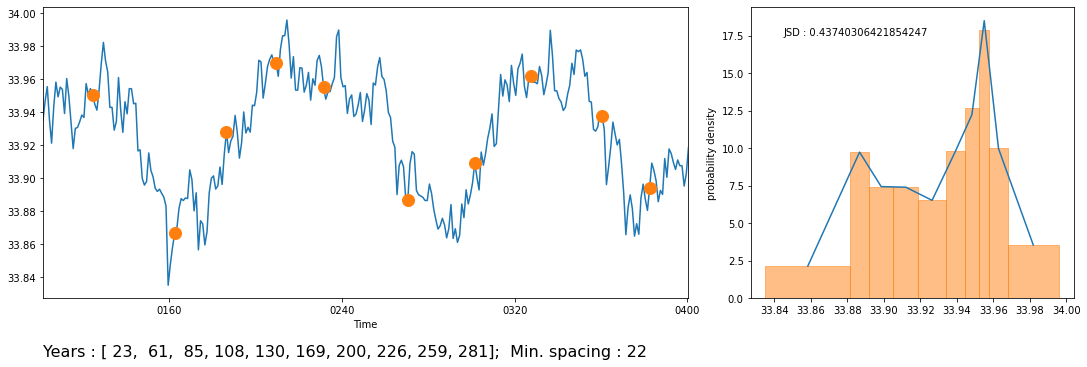

In [44]:
plot_distributions(sosalinity,years_orig-100,
                   bins=get_quantile_bins(sosalinity),
                   savefig=False)

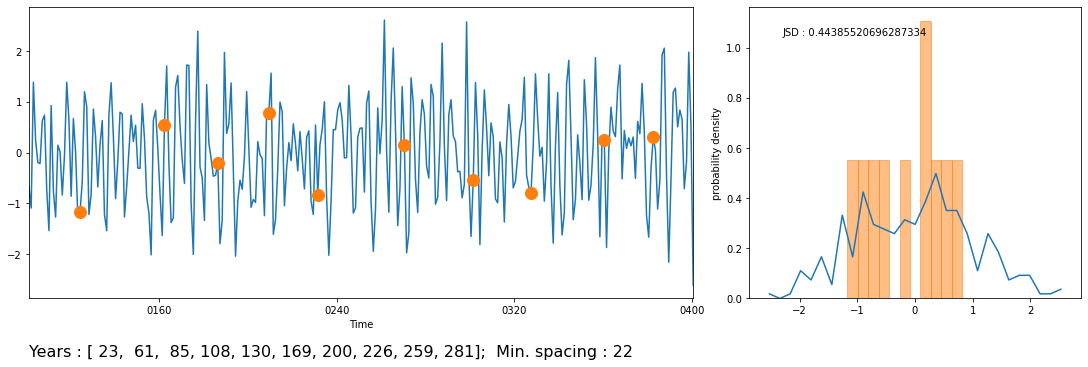

In [19]:
plot_distributions(nino34,years_orig-100,
                  savefig=False)

In [72]:
addyears = np.array([255, 343])
years = np.sort(np.append(years_orig,addyears))

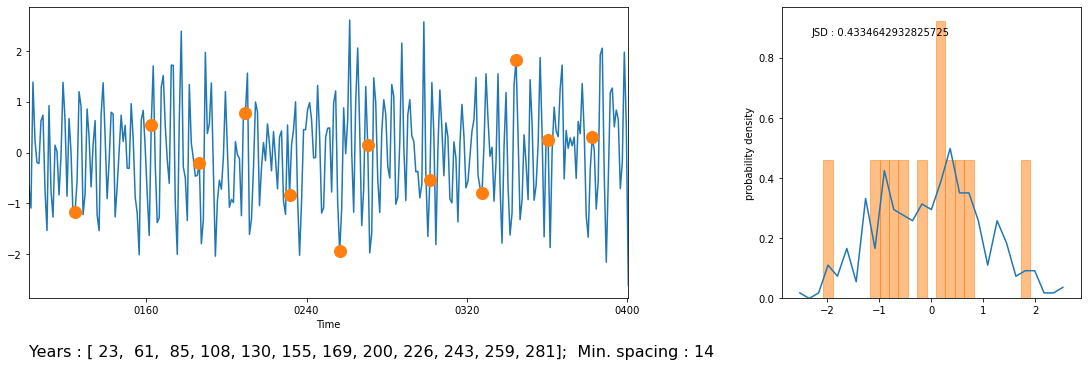

In [73]:
plot_distributions(nino34,years-100,
                  savefig=False)

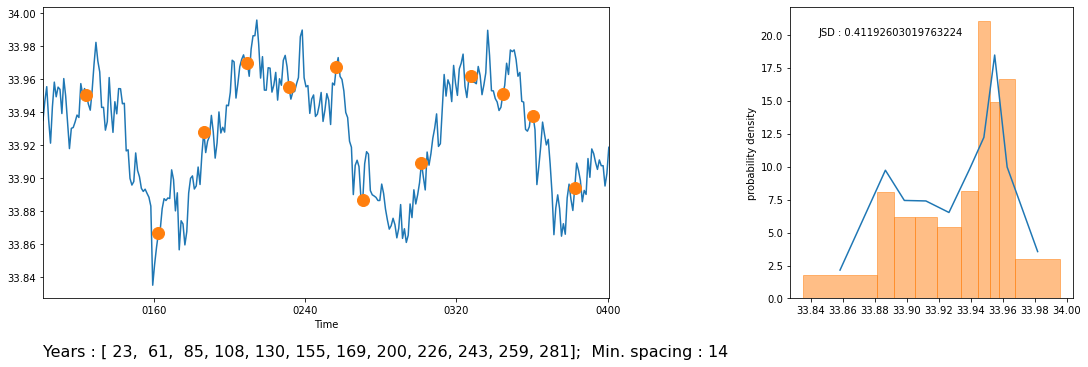

In [74]:
plot_distributions(sosalinity,years-100,
                   bins=get_quantile_bins(sosalinity),
                   savefig=False)

In [75]:
years

array([123, 161, 185, 208, 230, 255, 269, 300, 326, 343, 359, 381])

In [76]:
np.diff(years)

array([38, 24, 23, 22, 25, 14, 31, 26, 17, 16, 22])